In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os

import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
img_size = 288

In [ ]:
%run '/content/drive/MyDrive/obj_detect/tools.ipynb'
%run '/content/drive/MyDrive/obj_detect/models.ipynb'

In [ ]:
load_train_set = True
save_train_set = False

In [ ]:
if (not load_train_set):

  img_types = ['.png', '.jpg', '.jpeg']

  bear_train_folder = f'{folder_path}pics/bear_train/'
  bear_train_pics = os.listdir(bear_train_folder)

  deer_train_folder = f'{folder_path}pics/deer_train/'
  deer_train_pics = os.listdir(deer_train_folder)

  print(len(bear_train_pics))
  print(len(deer_train_pics))

In [ ]:
img_to_mask = lambda x: x[:x.find('.')] + '_mask' + x[x.find('.'):]
change_img_to_mask = lambda x, end: x[:x.find('.')] + '_mask' + end

In [ ]:
if (not load_train_set):
  X = []
  Y = []

In [ ]:
if (not load_train_set):
  for i in deer_train_pics:

    if(not accept_img(i)): continue
    if(i.find('_mask')!=-1): continue

    img_path = deer_train_folder + i
    img = cv2.imread(img_path)

    mask_path = deer_train_folder + img_to_mask(i)
    mask = cv2.imread(mask_path)

    if (mask is None):
      for img_type in img_types:
        mask_path = deer_train_folder + change_img_to_mask(i, img_type)
        mask = cv2.imread(mask_path)
        if (mask is not None): break
      if(mask is None): continue

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # resize images
    img = cv2.resize(img, (img_size, img_size))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.resize(mask, (img_size, img_size))

    # make mask picture only the contain mask and black out everything else
    mask[mask < 250] = 0

    # clean up mask
    clean_mask = cv2.GaussianBlur(mask, (7,7), sigmaX=0)
    clean_mask[clean_mask > 150] = 255
    clean_mask[clean_mask < 150] = 0

    np_zeros = np.zeros((2, img_size, img_size))
    np_zeros[0] = clean_mask

    X.append(img)
    Y.append(np_zeros)

In [ ]:
if (not load_train_set):
  for i in bear_train_pics:

    if(not accept_img(i)): continue
    if(i.find('_mask')!=-1): continue

    img_path = bear_train_folder + i
    img = cv2.imread(img_path)

    mask_path = bear_train_folder + img_to_mask(i)
    mask = cv2.imread(mask_path)

    if (mask is None):
      for img_type in img_types:
        mask_path = bear_train_folder + change_img_to_mask(i, img_type)
        mask = cv2.imread(mask_path)
        if (mask is not None): break
      if(mask is None): continue

    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # resize images
    img = cv2.resize(img, (img_size, img_size))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.resize(mask, (img_size, img_size))

    # make mask picture only the contain mask and black out everything else
    mask[mask < 250] = 0

    # clean up mask
    clean_mask = cv2.GaussianBlur(mask, (7,7), sigmaX=0)
    clean_mask[clean_mask > 150] = 255
    clean_mask[clean_mask < 150] = 0

    np_zeros = np.zeros((2, img_size, img_size))
    np_zeros[1] = clean_mask

    X.append(img)
    Y.append(np_zeros)

In [ ]:
if (not load_train_set):
  X = np.array(X)
  Y = np.array(Y)
  if (save_train_set):
    np.save(f'{folder_path}train_sets/bear_deer_X.npy', X)
    np.save(f'{folder_path}train_sets/bear_deer_Y.npy', Y)
    print('Successfully saved train set.')

else:
  X = np.load(f'{folder_path}train_sets/bear_deer_X.npy')
  Y = np.load(f'{folder_path}train_sets/bear_deer_Y.npy')
  print('Successfully loaded train set.')


print(f'Images shape {X.shape} | Masks shape{Y.shape}.')

Successfully loaded train set.
Images shape (52, 288, 288, 3) | Masks shape(52, 2, 288, 288).


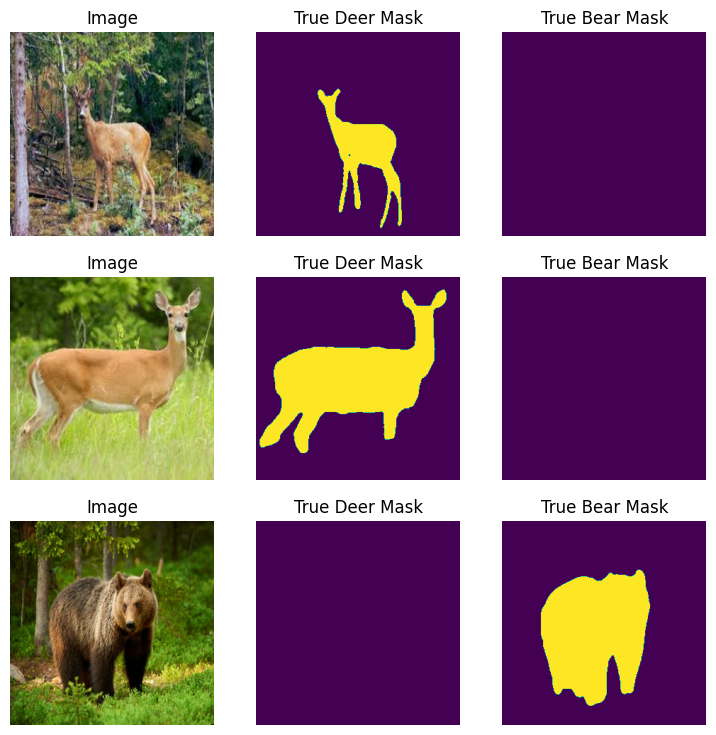

In [ ]:
rows  = 3
col = 3

fig, axes = plt.subplots(rows, col, figsize=(col*3, rows*3))

for i in range(rows):
  pic_num = i*10
  picture = X[pic_num]
  img = Y[pic_num]

  axes[i, 0].imshow(picture)
  axes[i, 0].set_title('Image')
  axes[i, 0].axis('off')

  axes[i, 1].imshow(img[0])
  axes[i, 1].set_title('True Deer Mask')
  axes[i, 1].axis('off')

  axes[i, 2].imshow(img[1])
  axes[i, 2].set_title('True Bear Mask')
  axes[i, 2].axis('off')

In [ ]:
torchX = torch.tensor(X.transpose(0, 3, 1, 2), dtype = torch.float32).to(device)
torchY = torch.tensor(Y, dtype = torch.float32).to(device)

In [ ]:
torchX.shape

torch.Size([52, 3, 288, 288])

In [ ]:
obj_detect = imgsegUnet(3, 2).to(device)

#optimizer, lr = learning rate
opt = Adam(obj_detect.parameters(), lr=1e-3)

#loss function
loss_fn = nn.MSELoss()

In [ ]:
# obj_detect.class_predictions_block[1] = nn.Conv2d(16, 2, kernel_size = (3,3), padding = 1)
obj_detect.class_predictions_block

Sequential(
  (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
load_pretrained_model = True
cross_walk_model = False

In [ ]:
if (load_pretrained_model):
  if (cross_walk_model):
    obj_detect = imgsegUnet(3, 1).to(device)
    with open(f'{folder_path}saved_models/cross_walk_segmentation_model_trained.pt', 'rb') as f:
            if(device == 'cpu'):
              obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
              print(f'Successfully loaded Cross Walk Segmentation model to cpu.')
            else:
              obj_detect.load_state_dict(load(f, map_location=torch.device(device)))
              print(f'Successfully loaded Cross Walk Segmentation model to {device}.')
    obj_detect.class_predictions_block[1] = nn.Conv2d(16, 2, kernel_size = (3,3), padding = 1)
  else:
    with open(f'{folder_path}saved_models/animal_segmentation_model_trained.pt', 'rb') as f:
            if(device == 'cpu'):
              obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
              print(f'Successfully loaded Animal Segmentation model to cpu.')
            else:
              obj_detect.load_state_dict(load(f, map_location=torch.device(device)))
              print(f'Successfully loaded Animal Segmentation model to {device}.')


Successfully loaded Animal Segmentation model to cuda.


In [ ]:
# obj_detect.class_predictions_block[1] = nn.Conv2d(16, 2, kernel_size = (3,3), padding = 1)
obj_detect.class_predictions_block

Sequential(
  (0): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
obj_detect.drop

Dropout2d(p=0.1, inplace=False)

In [ ]:
obj_detect = obj_detect.to(device)

In [ ]:
check_untrained_preds = True

In [ ]:
if (check_untrained_preds):
  untrained_preds = obj_detect(torchX[:5]).squeeze().to('cpu')
  print(untrained_preds.shape)
  untrained_preds_np = untrained_preds.detach().numpy()

torch.Size([5, 2, 288, 288])


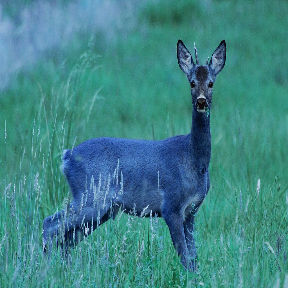

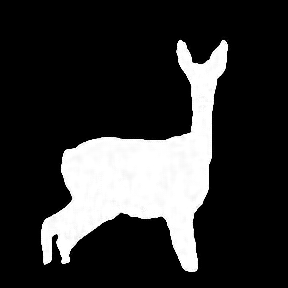

In [ ]:
if (check_untrained_preds):
  index=2
  cv2_imshow(X[index])
  cv2_imshow(untrained_preds_np[index][0])

In [ ]:
num_epochs = 100
epoch_print_interval = 10
batch_size = 26

train_time = True
updateModel = False

training_length = 'all'

In [ ]:
obj_detect = obj_detect.to(device)

In [ ]:
# Training flow
if (train_time):

    train = []
    if((training_length == 'all')or(training_length == 'All')): training_length = int(len(torchX))
    elif(training_length <= 1): training_length = int(training_length * len(torchX))

    type_out = (f'Training Size is {training_length}. Batch Size is {batch_size}. Maximum Epochs is {num_epochs}.')
    print(type_out)
    for v in type_out: print('_', end ='')
    print()

    for i in range(training_length):
        train.append((torchX[i], torchY[i]))

    trainloader = DataLoader(train, batch_size)

    start_time = time.time()
    last_loss = 'skip'
    for epoch in range(1, num_epochs+1):
        for batch in trainloader:
            x,y = batch
            x, y = x.to(device), y.to(device)
            # print(x, y)
            yhat = obj_detect(x)
            # print(yhat.shape, y.shape)

            loss = loss_fn(yhat, y)

            # backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()

        # print loss for epoch every so often
        if (epoch%epoch_print_interval==0):
          end_time = time.time()

          # format it nice
          if (epoch < 100): spaces = ' '
          else: spaces = ''

          print(f"| Epoch {epoch} loss is {str(loss.item())[:6]}{spaces} | Time is {str(end_time-start_time)[:4]} seconds |")
          start_time = time.time()

#     if (updateModel):
#         # save trained model
#         with open(f'{drive_path}obj_detect/saved_models/animal_segmentation_model_trained.pt', 'wb') as f:
#             save(obj_detect.state_dict(), f)
#         print(f'Successfully updated model.')

# ________________________________________________________________________________________________________________________________________________________________
else:
  obj_detect = imgsegUnet(3, 2).to(device)
  with open(f'{drive_path}obj_detect/saved_models/animal_segmentation_model_trained.pt', 'rb') as f:
        if(device == 'cpu'):
          obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
          print(f'Successfully loaded model to {device}.')
        else:
          obj_detect.load_state_dict(load(f))
          print(f'Successfully loaded model to {device}.')

Training Size is 52. Batch Size is 26. Maximum Epochs is 100.
_____________________________________________________________
| Epoch 10 loss is 51.282  | Time is 10.2 seconds |
| Epoch 20 loss is 49.116  | Time is 10.2 seconds |
| Epoch 30 loss is 65.548  | Time is 10.2 seconds |
| Epoch 40 loss is 80.696  | Time is 10.1 seconds |
| Epoch 50 loss is 48.044  | Time is 10.1 seconds |
| Epoch 60 loss is 62.064  | Time is 10.1 seconds |
| Epoch 70 loss is 59.321  | Time is 10.1 seconds |
| Epoch 80 loss is 62.983  | Time is 10.2 seconds |
| Epoch 90 loss is 48.322  | Time is 10.2 seconds |
| Epoch 100 loss is 66.472 | Time is 10.1 seconds |


In [ ]:
# updateModel = True
# if (updateModel):
#     # save trained model
#     with open(f'{folder_path}saved_models/animal_segmentation_model_trained.pt', 'wb') as f:
#         save(obj_detect.state_dict(), f)

#     print(f'Successfully updated model.')

In [ ]:
show_training_preds = False

In [ ]:
if (show_training_preds):

  # predictions on train set

  predictions = obj_detect(torchX).squeeze().to('cpu')
  predictions_np = predictions.detach().numpy()
  cpy_np = predictions_np.copy()

  rows  = 3
  col = 3

  fig, axes = plt.subplots(rows, col, figsize=(col*3, rows*3))

  # display training predictions

  for index in range(rows):
    pic_num = (index+4)*3
    img = cpy_np[pic_num].copy()

    threshold=200

    # img = cv2.GaussianBlur(img, (7,7), sigmaX=0)
    img[img > threshold] = 255
    img[img < threshold] = 0

    picture = X[pic_num]
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)

    axes[index, 0].imshow(picture.astype(int))
    axes[index, 0].set_title('Image')
    axes[index, 0].axis('off')

    axes[index, 1].imshow(img[0])
    axes[index, 1].set_title('Deer Detection')
    axes[index, 1].axis('off')

    axes[index, 2].imshow(img[1])
    axes[index, 2].set_title('Bear Detection')
    axes[index, 2].axis('off')

In [ ]:
# load test images

test_folder = f'{folder_path}pics/animal_seg_test/'
test_pics = os.listdir(test_folder)
test_sz = len(test_pics)
print(f'{test_sz} test pictures loaded.')

8 test pictures loaded.


In [ ]:
# convert images to tensors and determine predictions

test_np = []
for file_name in test_pics:
  if (not accept_img(file_name)): continue
  pic_path = test_folder + file_name
  test_img = cv2.imread(pic_path)
  test_img = cv2.resize(test_img, (img_size, img_size))
  # test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  test_np.append(test_img)

test_np = np.array(test_np)
test_torch = torch.tensor(test_np.transpose(0, 3, 1, 2), dtype = torch.float32)
test_torch = test_torch.to(device)
test_preds = obj_detect(test_torch).to('cpu')
tp_np = test_preds.detach().numpy()

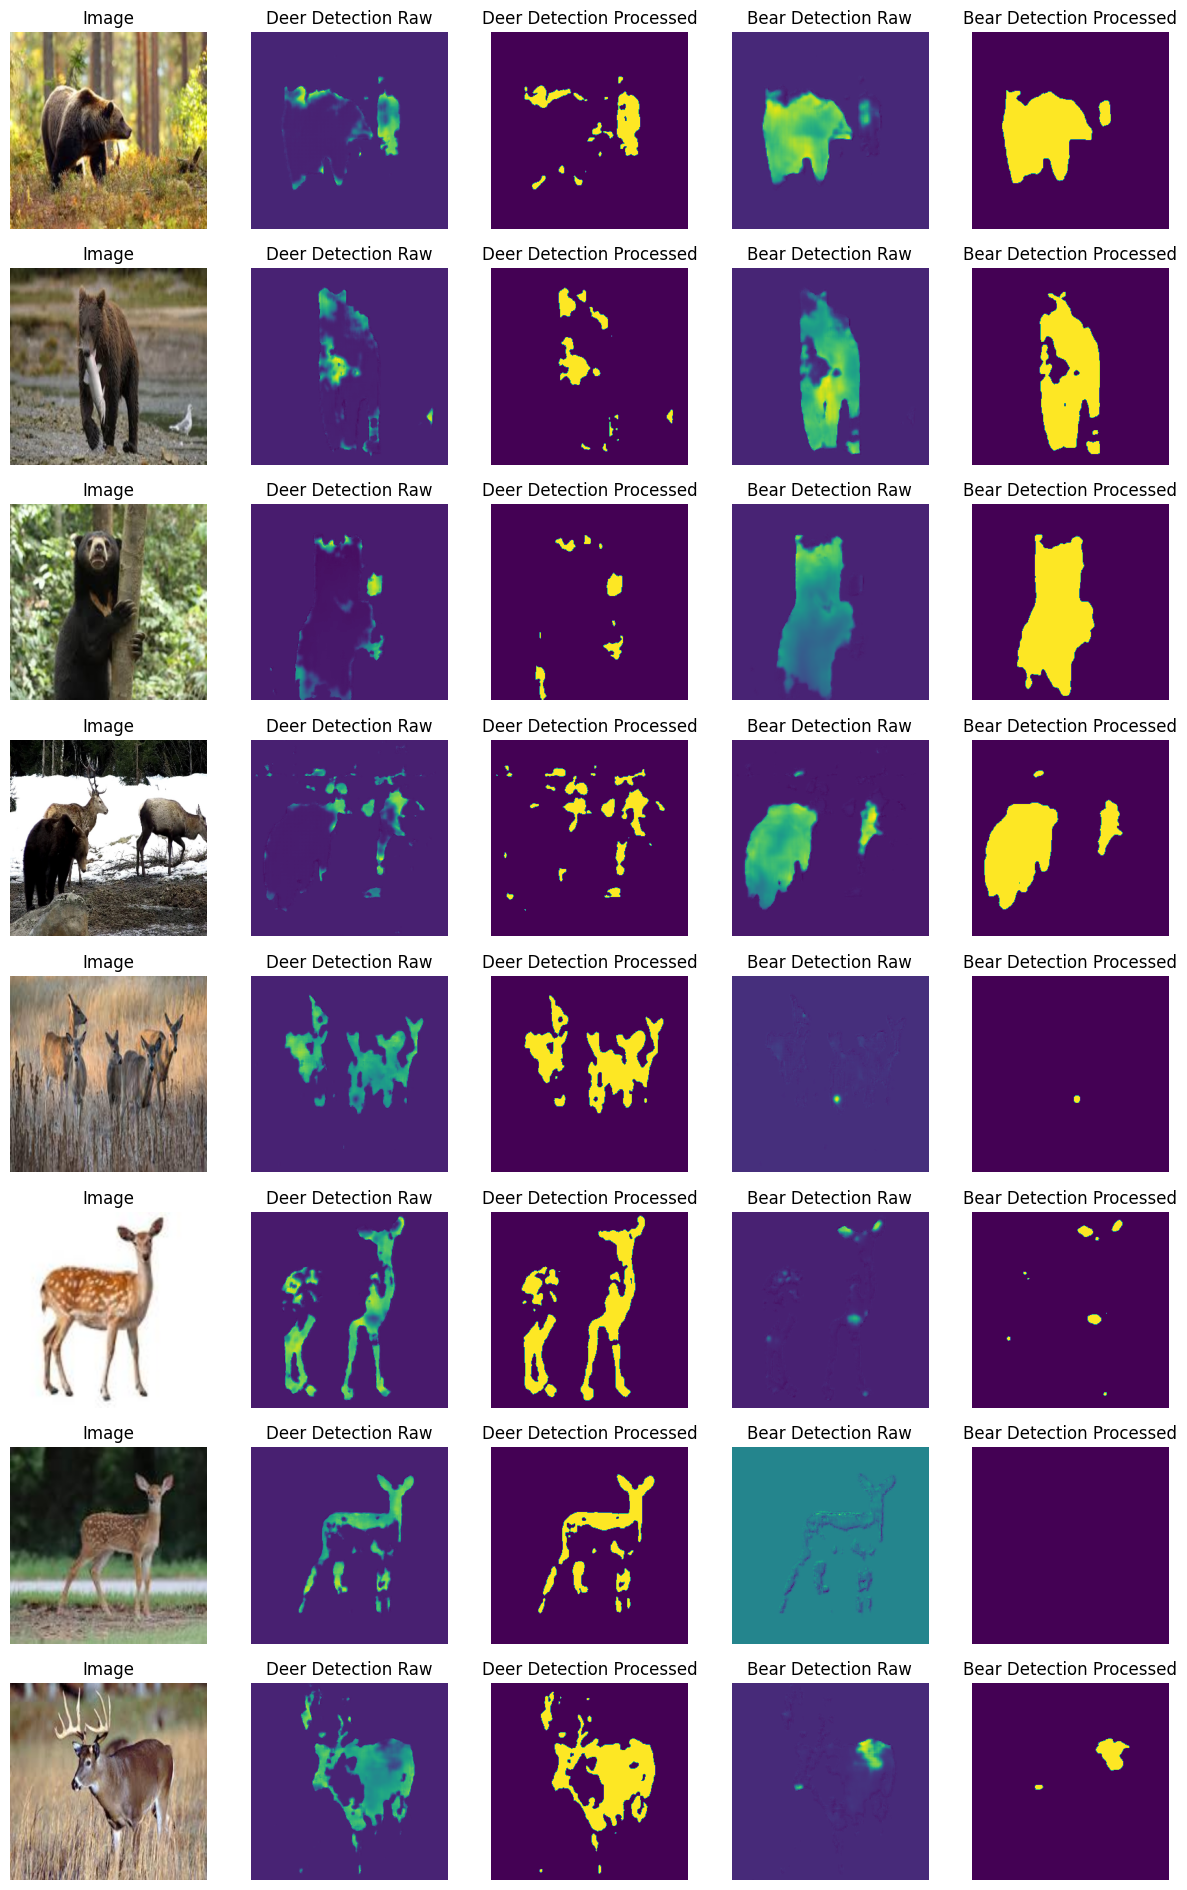

In [ ]:
# display test predictions

rows  = test_sz
col = 5

fig, axes = plt.subplots(rows, col, figsize=(col*3, rows*3))

for index in range(rows):

  # pic_num = (index+4)*3
  pic_num = index

  img = tp_np[pic_num].copy()
  deer_pred = img[0].copy()
  bear_pred = img[1].copy()

  # set threshold to eliminate noise from prediction masks
  threshold = 70

  # original image
  picture = test_np[pic_num]
  picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)

  axes[index, 0].imshow(picture.astype(int))
  axes[index, 0].set_title('Image')
  axes[index, 0].axis('off')

  # deer predictions

  axes[index, 1].imshow(deer_pred)
  axes[index, 1].set_title('Deer Detection Raw')
  axes[index, 1].axis('off')

  deer_pred = cv2.GaussianBlur(deer_pred, (5,5), sigmaX=0)
  deer_pred[deer_pred > threshold] = 255
  deer_pred[deer_pred < threshold] = 0

  axes[index, 2].imshow(deer_pred)
  axes[index, 2].set_title('Deer Detection Processed')
  axes[index, 2].axis('off')

  # bear predictions

  axes[index, 3].imshow(bear_pred)
  axes[index, 3].set_title('Bear Detection Raw')
  axes[index, 3].axis('off')

  bear_pred = cv2.GaussianBlur(bear_pred, (5,5), sigmaX=0)
  bear_pred[bear_pred > threshold] = 255
  bear_pred[bear_pred < threshold] = 0

  axes[index, 4].imshow(bear_pred)
  axes[index, 4].set_title('Bear Detection Processed')
  axes[index, 4].axis('off')